# Code for predictive coding

#### Loading necessary packages

In [162]:
%load_ext autoreload
%autoreload 2

import os
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from itertools import chain
from pathlib import Path
from NDDL2023 import PC_layer, Network, MultimodalNetwork

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import torch.nn.functional as F
# im = torch.Tensor(audio_data)
# output_feature_F = F.avg_pool2d(im, 2)

#### Code that contains classes and corresponding functions for the network: PC_layer, Network, Multimodalnetwork

In [192]:
methods = {"Matthias", "Rao", "Bogacz"}
class PC_layer:
    VALID_PARAMS = ['n', 'n_next', 'weights', 'inf_rate', 'learn_rate', 'activation', ]
    def __init__(self,n: int,n_next:int=0,*, inf_rate=0.05, learn_rate=0.005, activation="linear", method="old",):
        #TODO: need to fix activation function equations
        self.n = n
        self.n_next = n_next
        self.restart_activity()
        self.weights=[]
        if n_next is not None and n_next != 0:
            self.weights = self.generate_xavier_random_weights(self.n, self.n_next)
        self.inf_rate = np.float32(inf_rate) #TODO: check why it braeaks
        self.learn_rate = np.float32(learn_rate)
        self.activation = activation
        self.method = method
        return 
        
    @property
    def activation(self):
        return self._activation
    
    @activation.setter
    def activation(self,activation):
        self._activation = str(activation)
        self.set_activation()
        return
        
    def set_activation(self):
        activation = self.activation
        activation_functions = {
            "tanh": np.tanh,
            "relu": lambda x: np.maximum(x,0),
            "leaky relu": lambda x: np.maximum(x,0.1*x),
            "linear": lambda x: x,
            "sigmoid": lambda x: 1/(1 + np.exp(-x)), 
        }
        derivative_functions = {
            "tanh": lambda x: 1 - np.tanh(x)**2,
            "relu": lambda x: np.where(x > 0, 1, 0),
            "leaky relu": lambda x: np.where(x > 0, 1, 0.1),
            "linear": lambda x: np.ones_like(x) , 
            "sigmoid": lambda x: np.exp(-x)/(1+np.exp(-x))**2
        }
        if activation not in activation_functions:
            raise NotImplementedError(f"Invalid activation function: {activation}. Supported activations are: {', '.join(activation_functions.keys())}")

        self.activation_function = activation_functions[activation]
        self.act_derivative = derivative_functions[activation]
        return 
            
    def generate_xavier_random_weights(self, n_in:int, n_out:int, *, dist='uniform'):
        # using uniform rand:
        if dist == 'uniform':
            return (np.random.rand(n_in, n_out) - 0.5) * np.sqrt(2/(n_in + n_out))
        if dist == 'normal':
            return np.random.randn(n_in, n_out) * np.sqrt(2/(n_in + n_out))
        raise NotImplementedError(f"Unknown distribution: {dist}. Supported distributions are: 'uniform', 'normal'")
        
    def restart_activity(self):
        self.r = np.zeros([self.n], dtype = np.float32)
        self.e = np.zeros([self.n], dtype = np.float32)
        self.x = np.zeros([self.n], dtype = np.float32) #new method
     
    def inference_step_calc_error(self, r_next):
        '''calculates the error from next layer's prediction
        '''
        is_last_layer = self.n_next == 0
        if is_last_layer:
            return 
        # prediction based on the activity of next layer
        pred = self.weights.dot(r_next) 
        self.e  = self.r - pred
        if self.method != "old":
            self.e = self.x - pred
                   
    def inference_step_calc_r(self, BU_error):
        is_first_layer = len(BU_error) == 0
        if is_first_layer:
            return
        if self.method != "old":
            self.inference_step_calc_r_act_func(BU_error)
        else:    
            dr = self.inf_rate * (sum(BU_error) - self.e)
            self.r += dr 

    def inference_step_calc_r_act_func(self,BU_error):
        if self.method == "Matthias":
            dx = self.inf_rate * ( sum(BU_error) - self.e)
        elif self.method =="Dream":
            df = self.act_derivative(self.x)
            dx = self.inf_rate * (df* sum(BU_error) - self.e)
        self.x += dx
        self.r = self.activation_function(self.x)
                
    def learning_step(self,  r_next):
        dW = np.outer(self.e, r_next)
        return dW
    
    def update_weights(self, dW):
        self.weights += self.learn_rate * dW
    
    def calculate_MSE(self): 
        MSE = sum(self.e**2)/ self.n
        return MSE
      
    def save(self, dir, name="layer"):
        os.makedirs(dir, exist_ok=True)
        file_path = os.path.join(dir, name) 
        try:        
            kwargs = {}
            for x in PC_layer.VALID_PARAMS:
                kwargs[x] = getattr(self, x)
            
            np.savez_compressed(file_path, **kwargs )
        except:
            raise Exception(f"Error saving layer at {file_path}")

    def load(self, dir, name = "layer.npz"):
        file_path = os.path.join(dir, name)
        try:
            data = np.load(file_path)
            for x in PC_layer.VALID_PARAMS:
                setattr(self,x,data[x]) 
        except:
            raise Exception(f"Error loading layer at {file_path}")

class Network():
    VALID_PARAMS = ['n_layers', 'architecture', 'n_iter_inference', 'inf_rate', 'learn_rate', 'activation']
    def __init__(self, architecture: list[int], *, n_iter_inference:int=40, inf_rate = 0.05, learn_rate = 0.005, activation = "linear", method="old" ):
        self.n_layers = len(architecture)
        self.architecture = architecture
        self.n_iter_inference = n_iter_inference
        self.layers: list[PC_layer] = []
        for i in range(self.n_layers-1): 
            self.layers.append(PC_layer(self.architecture[i],self.architecture[i+1]))
        self.layers.append(PC_layer(self.architecture[-1])) 
        self.inf_rate = inf_rate
        self.learn_rate = learn_rate
        self.activation = activation
        self.method = method
        self.standardise_layer_params()
        
    def standardise_layer_params(self):
        for l in self.layers:
            l.inf_rate = self.inf_rate
            l.learn_rate = self.learn_rate
            l.activation = self.activation
            l.method = self.method 
        
    def reset_rates(self):
        for layer in self.layers:
            layer.restart_activity()  
    
    def inference_step(self, r_M = None, BU_error = []):
        for (l, layer) in enumerate(self.layers):
            if l<len(self.layers)-1:
                r_next = self.layers[l+1].r
            else:
                r_next = r_M
            layer.inference_step_calc_error(r_next)
            layer.inference_step_calc_r(BU_error = BU_error)
            if r_next is not None:
                BU_error = [layer.weights.T.dot(layer.e)]   
        return
    
    def infer(self, image, initialize =  True):
        if initialize:
            self.reset_rates()
            
        I = np.array(image).reshape([-1])
        self.layers[0].r = I 
        self.layers[0].x = I 
        for i in range(self.n_iter_inference):
            self.inference_step()         
        return

    def learning(self, r_M = None):
        for l, layer in enumerate(self.layers):
            if l<len(self.layers)-1:
                r_next = self.layers[l+1].r
            elif r_M is not None:
                r_next = r_M
            else:
                return
            dw=layer.learning_step(r_next = r_next)
            layer.update_weights(dw)
        return 
    
    def train(self, dataset , *, type='serial', epochs = 100, items_per_batch=100):
        if type == 'serial':
            self.train_serial(dataset, epochs)
        elif type == 'batch':
            self.train_batch(dataset, epochs, items_per_batch)
                 
    def train_serial(self, dataset , epochs = 100):
        for epoch in range(epochs):
            for image in dataset:
                self.infer(image)
                self.learning()    
                                
    def reconstruct(self, layer = 1, recon = None):
        if recon is None:
            recon = self.layers[layer].r
        for l in range(layer,0,-1):
            recon = self.layers[l-1].weights.dot(recon)
        return recon
    
    def calculate_MSE(self):
        e=[]
        for l in self.layers:
            e.append(l.calculate_MSE())
        return e
            
    def save(self,dir,name="model"):
        os.makedirs(dir, exist_ok=True)
        file_path = os.path.join(dir, name) 
        try:        
            kwargs = {}
            for x in Network.VALID_PARAMS:
                kwargs[x] = getattr(self, x)
            
            np.savez_compressed(file_path, **kwargs )
        except:
            raise Exception(f"Error saving network at {file_path}")
        
        for i in range(self.n_layers):
            self.layers[i].save(dir,name= name.rsplit(".",1)[0]+"layer"+str(i))
        print("saved: {}".format(file_path))

    def load(self,dir,name = "model.npz"):
        file_path = os.path.join(dir, name)
        try:
            data = np.load(file_path)
            for x in Network.VALID_PARAMS:
                setattr(self,x,data[x]) 
        except:
            raise Exception(f"Error loading layer at {file_path}")
        self.layers=[]
        for i in range(self.n_layers):
            L = PC_layer(1)
            L.load(dir,name= name.rsplit(".",1)[0]+"layer"+str(i)+".npz")
            self.layers.append(L)
        print("loaded: {}".format(file_path))
    
class MultimodalNetwork():
    VALID_PARAMS = ['n_iter_inference', 'inf_rate', 'learn_rate', 'activation']
    def __init__(self, mod1, mod2, joint,*, n_iter_inference:int=40, inf_rate = 0.05, learn_rate = 0.005, activation = "linear", **kwargs):
        self.mod1: Network = Network(mod1, n_iter_inference= n_iter_inference, inf_rate=0.5 , learn_rate= 0.01)
        self.mod2: Network = Network(mod2, n_iter_inference= n_iter_inference, inf_rate=0.05, learn_rate=0.01)
        self.joint: Network =  Network(joint, n_iter_inference= n_iter_inference)
        self.connect()
        self.n_iter_inference = n_iter_inference
        self.inf_rate = inf_rate
        self.learn_rate = learn_rate
        self.activation = activation
        self.standardise_networks()       
        #TODO: implement sth to call the standardise method every time one of this values is changed
        
    def connect(self):
        L1 = self.mod1.layers[-1]
        L2 = self.mod2.layers[-1]
        L_joint = self.joint.layers[0]
        L1.n_next = L_joint.n
        L2.n_next = L_joint.n
        L1.weights = L1.generate_xavier_random_weights(L1.n, L1.n_next)
        L2.weights = L2.generate_xavier_random_weights(L2.n, L2.n_next)
    
    def standardise_networks(self):
        '''
        makes sure that all the networks and all the layers inside a network
        have the exact same parameters
        '''
        for net in [self.mod1,self.mod2,self.joint]:
            net.n_iter_inference = self.n_iter_inference
            net.inf_rate = self.inf_rate
            net.learn_rate = self.learn_rate
            net.activation = self.activation
            net.standardise_layer_params()

    def reset_rates(self):
        self.mod1.reset_rates()
        self.mod2.reset_rates()
        self.joint.reset_rates()
    
    def inference_step(self):
        # each modality performs a single inference step 
        self.mod1.inference_step(r_M = self.joint.layers[0].r)
        self.mod2.inference_step(r_M = self.joint.layers[0].r)
        # self.joint.inference_step(r_M = self.joint.layers[0].r)
        # the joint modality performs a single inference 
        BU1 = self.mod1.layers[-1].weights.T.dot(self.mod1.layers[-1].e)
        BU2 = self.mod2.layers[-1].weights.T.dot(self.mod2.layers[-1].e)
        # BU1 = self.joint.layers[0].weights.T.dot(self.mod1.layers[-1].e)
        # BU2 = self.joint.layers[0].weights.T.dot(self.mod2.layers[-1].e)
        # BU_joint = self.joint.layers[-1].weights.T.dot(self.joint.layers[-1].e)
        self.joint.inference_step(BU_error= [BU1, BU2])

    def infer(self,image1, image2, initialize = True):
        if initialize:
            self.reset_rates()
        self.mod1.layers[0].r = np.array(image1).reshape([-1])
        self.mod2.layers[0].r = np.array(image2).reshape([-1]) 
        for i in range(self.n_iter_inference):
            self.inference_step()         

    def learning(self):
        self.mod1.learning(r_M = self.joint.layers[0].r)
        self.mod2.learning(r_M = self.joint.layers[0].r)
        self.joint.learning()
        
    def train(self, data1, data2, epochs=30):
        for epoch in range(epochs):
            for (I1,I2) in zip(data1,data2):
                self.infer(I1,I2)
                self.learning()             
    
    def reconstruct(self,modal, layer):
        if modal == "uni":
            recon1 = self.mod1.reconstruct(layer)
            recon2 = self.mod2.reconstruct(layer)
        if modal=="joint":
            recon = self.joint.reconstruct(layer)
            rec1 = self.mod1.layers[-1].weights.dot(recon)
            rec2 = self.mod2.layers[-1].weights.dot(recon)
            recon1 = self.mod1.reconstruct(layer= self.mod1.n_layers-1,recon = rec1)
            recon2 = self.mod2.reconstruct(layer= self.mod2.n_layers-1,recon = rec2)
        return recon1, recon2
    
    def infer_unimodal(self,modality,image, initialize = True):
        '''
        presents the image to the specified modality,
        performs inference on one modality and the joint network
        '''
        if modality ==0:
            net = self.mod1
        else:
            net = self.mod2
            
        if initialize:
            self.reset_rates()
        net.layers[0].r = np.array(image).reshape([-1])
        for i in range(self.n_iter_inference):
            net.inference_step(r_M = self.joint.layers[0].r)
            #topmost layer gets no prediction and send no BU_error
            BU = net.layers[-1].weights.T.dot(net.layers[-1].e)
            self.joint.inference_step(BU_error= [BU])
    
    def calculate_MSE(self):
        e1 = self.mod1.calculate_MSE()
        e2 = self.mod2.calculate_MSE()
        e3 = self.joint.calculate_MSE()
        return e1,e2,e3
    
    def save(self,dir,name = "Multimodal",name1="Mod1.npz",name2="Mod2.npz"):
        os.makedirs(dir, exist_ok=True)
        file_path = os.path.join(dir, name) 
        try:        
            kwargs = {}
            for x in MultimodalNetwork.VALID_PARAMS:
                kwargs[x] = getattr(self, x)    
            np.savez_compressed(file_path, **kwargs )
        except:
            raise Exception(f"Error saving multimodal network at {file_path}")
        self.mod1.save(dir,name1)
        self.mod2.save(dir,name2)
        self.joint.save(dir,"joint")
        print("saved: {}".format(file_path))
    
    def load(self,dir, name, name1="Mod1.npz", name2="Mod2.npz"):
        file_path = os.path.join(dir, name)
        try:
            data = np.load(file_path)
            for x in MultimodalNetwork.VALID_PARAMS:
                setattr(self,x,data[x]) 
        except:
            raise Exception(f"Error loading layer at {file_path}")
        self.mod1.load(dir,name1)
        self.mod2.load(dir,name2)
        self.joint.load(dir,"joint")

#### Data loaden en preprocessen

Loading visual data

In [193]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

c:\Users\31629\miniconda3\envs\NDDL\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Getting random 125 images with labels of each class

In [247]:
from itertools import chain

# Define the classes you want to select
selected_classes_vis = [0, 6, 7]

indices_vis = []

for digit in selected_classes_vis:
    digit_indices_vis = np.where(mnist.target.astype('int64') == digit)[0]
    selected_indices_vis = np.random.choice(digit_indices_vis, 400, replace=False)
    indices_vis.append(selected_indices_vis)

flat_indices_vis = list(chain(*indices_vis))

images = mnist.data.astype('float32')
images /= 255.0
image_data = np.empty((1200, 784))
for index in range(1200):
    image_data[index] = images[flat_indices_vis[index]]
print(image_data.shape)

image_label = np.repeat(selected_classes_vis, 400)
print(image_label.shape)


(1200, 784)
(1200,)


In [248]:
print(image_label)

[0 0 0 ... 7 7 7]


Loading audio data

In [227]:
AUDIO_PATH_32 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/32/")
AUDIO_PATH_33 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/33/")
AUDIO_PATH_34 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/34/")
AUDIO_PATH_35 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/35/")
AUDIO_PATH_36 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/36/")
AUDIO_PATH_37 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/37/")
AUDIO_PATH_38 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/38/")
AUDIO_PATH_39 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/39/")
AUDIO_PATH_40 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/40/")
AUDIO_PATH_41 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/41/")
AUDIO_PATH_42 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/42/")
AUDIO_PATH_43 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/43/")
AUDIO_PATH_44 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/44/")
AUDIO_PATH_45 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/45/")
AUDIO_PATH_46 = Path("C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/data/MNIST_audio_data/46/")
# Get full paths of all WAV files in the directory

wav_files_32 = [os.path.join(AUDIO_PATH_32, f) for f in os.listdir(AUDIO_PATH_32) if f.endswith('.wav')]
wav_files_33 = [os.path.join(AUDIO_PATH_33, f) for f in os.listdir(AUDIO_PATH_33) if f.endswith('.wav')]
wav_files_34 = [os.path.join(AUDIO_PATH_34, f) for f in os.listdir(AUDIO_PATH_34) if f.endswith('.wav')]
wav_files_35 = [os.path.join(AUDIO_PATH_35, f) for f in os.listdir(AUDIO_PATH_35) if f.endswith('.wav')]
wav_files_36 = [os.path.join(AUDIO_PATH_36, f) for f in os.listdir(AUDIO_PATH_36) if f.endswith('.wav')]
wav_files_37 = [os.path.join(AUDIO_PATH_37, f) for f in os.listdir(AUDIO_PATH_37) if f.endswith('.wav')]
wav_files_38 = [os.path.join(AUDIO_PATH_38, f) for f in os.listdir(AUDIO_PATH_38) if f.endswith('.wav')]
wav_files_39 = [os.path.join(AUDIO_PATH_39, f) for f in os.listdir(AUDIO_PATH_39) if f.endswith('.wav')]
wav_files_40 = [os.path.join(AUDIO_PATH_40, f) for f in os.listdir(AUDIO_PATH_40) if f.endswith('.wav')]
wav_files_41 = [os.path.join(AUDIO_PATH_41, f) for f in os.listdir(AUDIO_PATH_41) if f.endswith('.wav')]
wav_files_42 = [os.path.join(AUDIO_PATH_42, f) for f in os.listdir(AUDIO_PATH_42) if f.endswith('.wav')]
wav_files_43 = [os.path.join(AUDIO_PATH_43, f) for f in os.listdir(AUDIO_PATH_43) if f.endswith('.wav')]
wav_files_44 = [os.path.join(AUDIO_PATH_44, f) for f in os.listdir(AUDIO_PATH_44) if f.endswith('.wav')]
wav_files_45 = [os.path.join(AUDIO_PATH_45, f) for f in os.listdir(AUDIO_PATH_45) if f.endswith('.wav')]
wav_files_46 = [os.path.join(AUDIO_PATH_46, f) for f in os.listdir(AUDIO_PATH_46) if f.endswith('.wav')]



wav_files = wav_files_32 + wav_files_33 + wav_files_34 + wav_files_35 + wav_files_36 + wav_files_37 + wav_files_38 + wav_files_39 + wav_files_40 + wav_files_41 + wav_files_42 + wav_files_43 + wav_files_44 + wav_files_45 + wav_files_46

len(wav_files)


7500

Filtering and shifting audiofiles, and converting them into spectograms with corresponding labels

In [228]:
data = []
labels = []

for file in wav_files:
    y, sr = librosa.load(file, sr = None)
    
    label = file.split("\\")[-1].split("_")[0] 
    label = int(label)
    print("doing for ", label)
    if y.shape[0] > 33000:

        y = y[5000:33000,]

        img = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=56, n_fft = 2048, hop_length = 508, fmin = 64, fmax = 2048)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = np.power(img, 1/4)
        data.append(img)
        
        labels.append(label)

    elif y.shape[0] > 30500:

        y = y[2500:30500,]

        img = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=56, n_fft = 2048, hop_length = 508, fmin = 64, fmax = 2048)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = np.power(img, 1/4)
        data.append(img)
        
        # x = int(file[14])
        labels.append(label)

    elif y.shape[0] > 28000:

        y = y[0:28000,]

        img = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=56, n_fft = 2048, hop_length = 508, fmin = 64, fmax = 2048)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = np.power(img, 1/4)
        data.append(img)
        
        # x = int(file[14])
        labels.append(label)

    else:
        continue
    
audio_data = np.array(data) # create 3d tensor from list
print(audio_data.shape)

audio_label = np.array(labels)
print(audio_label.shape)

doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  0
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1
doing for  1

In [236]:
numbers = np.count_nonzero(audio_label ==4 )

    
print(numbers)

498


Getting random audiofiles per class, and making it to a 125 per class.

In [244]:
from itertools import chain

# Define the classes you want to select
selected_classes = [0, 6, 7]

# Initialize the list to store selected indices
indices = []

# Select 400 samples for each selected class
for digit in selected_classes:
    digit_indices = np.where(audio_label == digit)[0]
    selected_indices = np.random.choice(digit_indices, 400, replace=False)
    indices.append(selected_indices)

# Concatenate the selected indices
flat_indices = list(chain(*indices))

# Use the selected indices to extract the corresponding data
audio_data_2d = audio_data.reshape(audio_data.shape[0], -1)
audio_data= audio_data_2d[flat_indices]

# Repeat the process for labels
audio_label = np.repeat(selected_classes, 400)

# Print the shapes of the selected data and labels
print("Selected Audio Data Shape:", audio_data.shape)
print("Selected Audio Label Shape:", audio_label.shape)


Selected Audio Data Shape: (1200, 3136)
Selected Audio Label Shape: (1200,)


In [245]:
print(audio_label)

[0 0 0 ... 7 7 7]


In [174]:
#work with 2 classes only

# Filter for classes 0 and 1
selected_classes = [0, 1, 2]

# Create a mask for the selected classes
mask = np.isin(audio_label, selected_classes)

# Apply the mask to filter data and labels
audio_data_2_classes = audio_data[mask]
audio_label_2_classes = audio_label[mask]

(1250, 3136)

Shuffling the image data, audio data and image and audio labels in the same way, so they still 'match' but are randomized

In [249]:
# Set a random seed with int 42
np.random.seed(42)

# Shuffle the data
permutation = np.random.permutation(len(audio_label))
image_data_s = image_data[permutation]
image_label_s = np.array(image_label)[permutation]
audio_data_s = audio_data[permutation]
audio_label_s = np.array(audio_label)[permutation]


# #and for the two classes
# permutation_2_classes = np.random.permutation(len(audio_label_2_classes))
# audio_data_2_classes_s = audio_data_2_classes[permutation_2_classes]
# audio_label_2_classes_s = audio_label_2_classes[permutation_2_classes]

## Plotting examples of visual and audio data

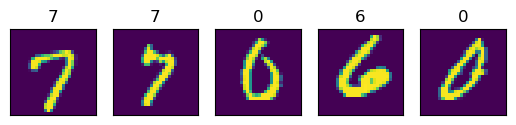

In [250]:
def visual_plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[0:5].reshape(5, 28, 28), y[0:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
        
visual_plot_example(image_data_s, image_label_s)

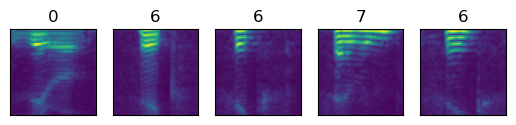

In [251]:
def audio_plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[15:20].reshape(5, 56, 56), y[15:20])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
      

audio_plot_example(audio_data_s, audio_label_s)

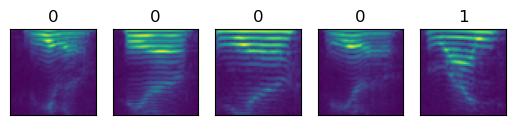

In [182]:
#and for the 2 classes
# def audio_plot_example(X, y):
#     """Plot the first 5 images and their labels in a row."""
#     for i, (img, y) in enumerate(zip(X[0:5].reshape(5, 56, 56), y[0:5])):
#         plt.subplot(151 + i)
#         plt.imshow(img)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(y)
      

# audio_plot_example(audio_data_2_classes_s, audio_label_2_classes_s)

Checking if we indeed have the same amount of data per class

In [254]:
image_count = []
for i in range(10):
    numbers = np.count_nonzero(image_label == i)
    image_count.append(numbers)
    
print(image_count)

audio_count = []
for i in range(10):
    numbers = np.count_nonzero(audio_label == i)
    audio_count.append(numbers)
    
print(audio_count)

#but let's work with less classes

[400, 0, 0, 0, 0, 0, 400, 400, 0, 0]
[400, 0, 0, 0, 0, 0, 400, 400, 0, 0]


## Supervised learning

In [255]:
image_data_s_train, image_data_s_test, image_label_s_train, image_label_s_test, audio_data_s_train, audio_data_s_test, audio_label_s_train, audio_label_s_test = train_test_split(
    image_data_s, # array of 1250 x 3136
    image_label_s, # array of 1250
    audio_data_s, # array of 1250 x 784
    audio_label_s, # array of 1250
    test_size=0.2, # ratio test data vs train data
    random_state=31, # perform the same random split using seed
    stratify=image_label_s, # make sure the numbers are evenly split
)

In [183]:
# #and for the 2 classes
# audio_data_2_classes_s_train, audio_data_2_classes_s_test, audio_label_2_classes_s_train, audio_label_2_classes_s_test = train_test_split(
#     audio_data_2_classes_s, # array of 1250 x 784
#     audio_label_2_classes_s, # array of 1250
#     test_size=0.2, # ratio test data vs train data
#     random_state=31, # perform the same random split using seed
#     stratify=audio_label_2_classes_s, # make sure the numbers are evenly split
# )

In [256]:
# print(audio_data_2_classes_s_test.shape)
# print(audio_data_2_classes_s_train.shape)

print(image_data_s_test.shape)
print(image_data_s_train.shape)

print(audio_data_s_test.shape)
print(audio_data_s_train.shape)

(240, 784)
(960, 784)
(240, 3136)
(960, 3136)


In [ ]:
# One-hot encoding of labels, stored in the "ohe_labels_image_train" variable
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ohe_labels_image_train = np.zeros((len(image_label_s_train), 10))
for i in range(len(image_label_s_train)):
    j = np.where(categories == image_label_s_train[i])
    ohe_labels_image_train[i, j] = 1

In [ ]:
# kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
# result = np.zeros(im.shape)
# 
# # Output array
# for ii in range(im.shape[0] - 3):
#     for jj in range(im.shape[1] - 3):
#         result[ii, jj] = (im[ii*2:ii*2+3, jj*2:jj*2+3] * kernel).sum()
# 
# # Print result
# print(result)

## The network

Making the network

In [258]:
mod1_image = Network([784,625,400])
mod2_audio = Network([3136,1568,400]) 
joint_architecture = [400, 200]  # Combining input sizes of mod1_image and mod2_audio

M1 = MultimodalNetwork(mod1_image.architecture, mod2_audio.architecture, joint=joint_architecture,
                       n_iter_inference=40, inf_rate = 0.01, learn_rate = 0.005, activation = "relu")


image_network = Network(mod1_image.architecture, n_iter_inference=40, inf_rate=0.01, learn_rate= 0.005, activation= "relu" )

audio_network = Network(mod2_audio.architecture, n_iter_inference=40, inf_rate=0.01, learn_rate= 0.005, activation= "relu" )

#tune network architecture, so instead of going from 3000 to 600, go 3000 to 1500, and adding more layers doesnt help a lot. we just need more training. #train unimodal first

Training

(3 epochs = 20 min)

In [271]:
M1.train(image_data_s_train, audio_data_s_train, epochs=3)
M1.calculate_MSE

# image_network.train(image_data_s, epochs=2)
# MSE_visual = image_network.calculate_MSE()


print(M1.calculate_MSE)
# audio_network.train(audio_data_s, epochs=3)


KeyboardInterrupt: 

In [260]:
#Training loop for image network
mse_history_image = []
epochs = 1
for epoch in range(epochs):
    M1.train(image_data_s_train, audio_data_s_train, epochs=2)
    mse = M1.calculate_MSE()
    mse_history_image.append(np.array(mse))

# Plot MSE for each layer for the image network
mse_per_layer_image = np.array(mse_history_image).T

for layer_index, mse_layer in enumerate(mse_per_layer_image):
    plt.plot(range(1, epochs + 1), mse_layer, label=f'Image Network Layer {layer_index + 1}')

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE of the layers over the epochs')
plt.show()

#less classes to show the proof of concept that it works for these hyperparameters so i can do more epochs

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [148]:
print(mse_per_layer_image)

[[0.01613468 0.00943957]
 [0.00388605 0.00375043]
 [0.         0.        ]]


In [262]:
MODEL_PATH = Path('C:/Users/31629/Documents/Cognitive Neurobiology and Clinical Neurophysiology/NDDL/NDDL-predictive-coding/models')
image_network.save(MODEL_PATH, name = 'multimodal_epochs_3')

saved: C:\Users\31629\Documents\Cognitive Neurobiology and Clinical Neurophysiology\NDDL\NDDL-predictive-coding\models\multimodal_epochs_3


Defining input data for the network

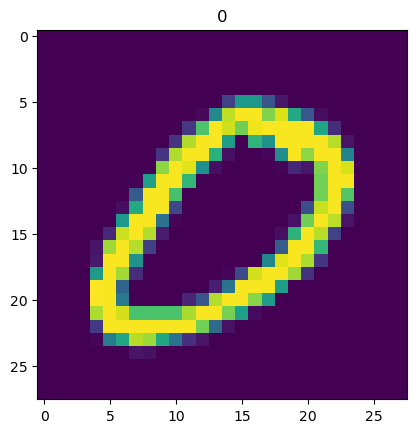

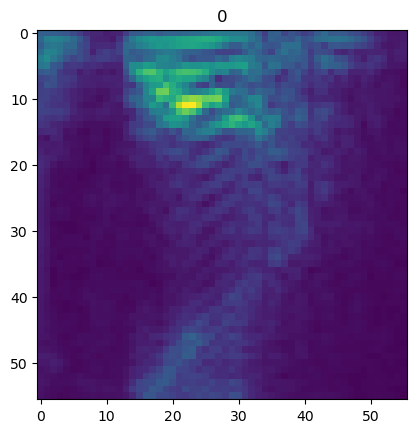

In [272]:
image_picker = 3

input_image = image_data_s_test[image_picker]
plt.imshow(input_image.reshape(28, 28))
plt.title(image_label_s_test[image_picker])
plt.show()

input_audio = audio_data_s_test[image_picker]
plt.imshow(input_audio.reshape(56, 56))
plt.title(audio_label_s_test[image_picker])
plt.show()

Infering based on the input data

In [283]:
M1.infer_unimodal(modality=0, image=input_image, initialize=True)
M1.infer_unimodal(modality=1, image=input_audio, initialize=True)
#audio_network.infer(image==input_audio, initialize=True)

#can be either input image or input spectogram

# M1.infer_unimodal(modality=0, image=input_image, initialize=True)
# M1.infer_unimodal(modality=1, image=input_audio, initialize=True)

Reconstructing the representation (r)

Unimodal

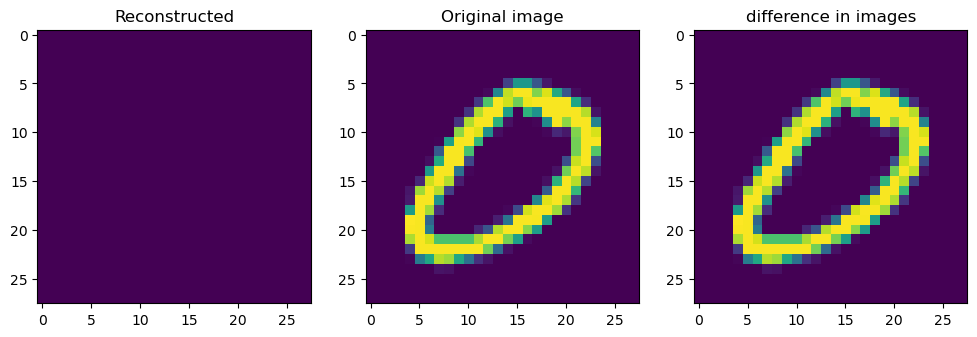

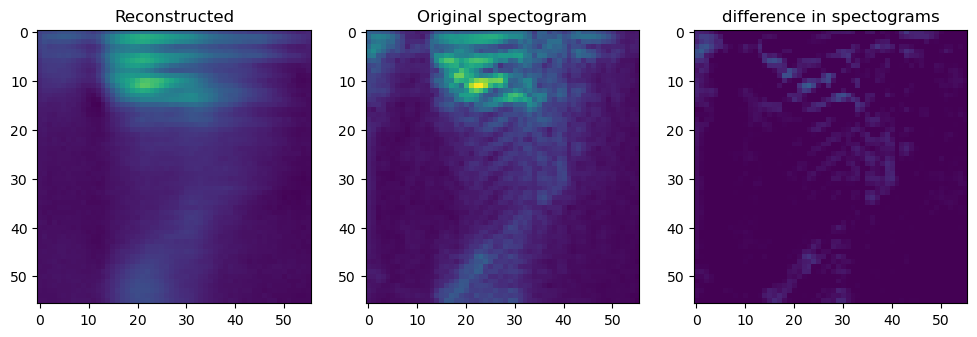

In [284]:
mod1, mod2 = M1.reconstruct(modal='uni', layer=1)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(mod1.reshape(28,28), vmin=0, vmax=1)
axes[0].set_title('Reconstructed')

axes[1].imshow(input_image.reshape(28, 28), vmin=0, vmax=1)
axes[1].set_title('Original image')

diff_images = input_image - mod1

axes[2].imshow(diff_images.reshape(28,28), vmin=0, vmax=1)
axes[2].set_title('difference in images')
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(mod2.reshape(56,56), vmin=0, vmax=1)
axes[0].set_title('Reconstructed')

axes[1].imshow(input_audio.reshape(56, 56), vmin=0, vmax=1)
axes[1].set_title('Original spectogram')

diff_images = input_audio - mod2

axes[2].imshow(diff_images.reshape(56,56), vmin=0, vmax=1)
axes[2].set_title('difference in spectograms')

plt.show()

#can be either the image or the spectogram

# mod1, mod2 = M1.reconstruct(modal='uni', layer=0)

# #original 
# input_audio = audio_data_s[image_picker]
# plt.imshow(input_audio.reshape(56, 56), vmin=0, vmax=1)
# plt.title(audio_label_s[image_picker])
# plt.show()

#plt.imshow(mod1.reshape(28, 28))
# plt.imshow(mod2.reshape(56, 56), vmin=0, vmax=1)
# plt.colorbar()
# plt.title('reconstructed image')
# plt.show()

#specify in imshow that we want to have the same scale, so normalizing, so outputs are between 0 and 1 but when we reconstruct,we need to specify. if it is still weak, we need more inference
#we need vmax and vmin in imshow. 

from joint

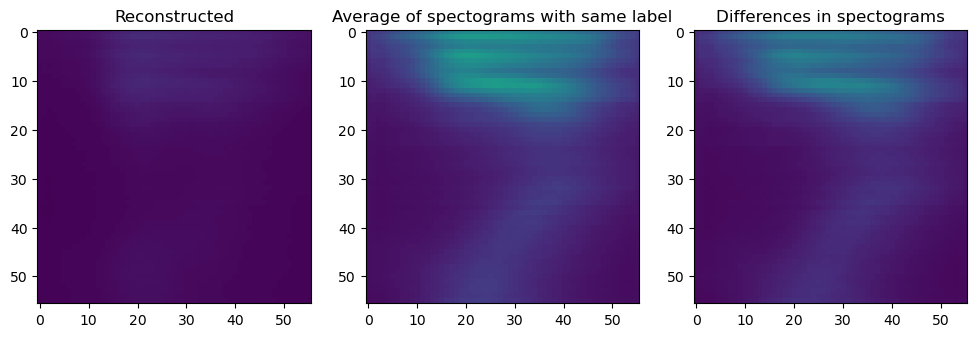

In [306]:
#can either retrieve the input image or input spectogram
M1.infer_unimodal(modality=0, image=input_image, initialize=True)
#M1.infer_unimodal(modality=1, image=input_audio, initialize=True)

mod1, mod2 = M1.reconstruct(modal='joint', layer=0)

#visual
# fig, axes = plt.subplots(1, 3, figsize=(12,4))
# axes[0].imshow(mod1.reshape(28,28), vmin=0, vmax=1)
# axes[0].set_title('Reconstructed')

# #make ground truth of what this number should look like, so average of all mnist with label 0 in train
# # Filter instances with label 0
# image_data_s_train_label0 = image_data_s_train[image_label_s_train == 0]
# image_data_s_train_truth = np.mean(image_data_s_train_label0, axis=0)
# image_data_s_train_truth = np.mean(image_data_s_train, axis=0)
# axes[1].imshow(image_data_s_train_truth.reshape(28, 28), vmin=0, vmax=1)
# axes[1].set_title('Ground truth')

# diff_images_cross = image_data_s_train_truth - mod1

# axes[2].imshow(diff_images_cross.reshape(28,28), vmin=0, vmax=1)
# axes[2].set_title('difference in images')
# plt.show()

#audio

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(mod2.reshape(56,56), vmin=0, vmax=1)
axes[0].set_title('Reconstructed')

#and make a ground truth of what this spectogram is supposed to look like, aka an average of all spectograms with label 0 in the train
audio_data_s_train_label0 = audio_data_s_train[audio_label_s_train == 0]
audio_data_s_train_truth = np.mean(audio_data_s_train_label0, axis=0)
axes[1].imshow(audio_data_s_train_truth.reshape(56, 56), vmin=0, vmax=1)
axes[1].set_title('Average of spectograms with same label')

diff_audio_cross = audio_data_s_train_truth - mod2
axes[2].imshow(diff_audio_cross.reshape(56, 56), vmin=0, vmax=1)
axes[2].set_title('Differences in spectograms')
plt.show()

In [297]:
image_data_s_train_truth.shape

(784,)

Parameter tuning

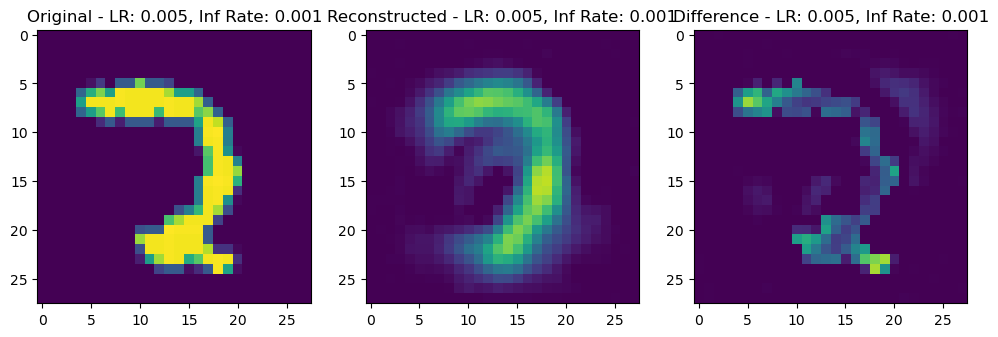

LR: 0.005, Inf Rate: 0.001, Average MSE: 0.01842687534804333


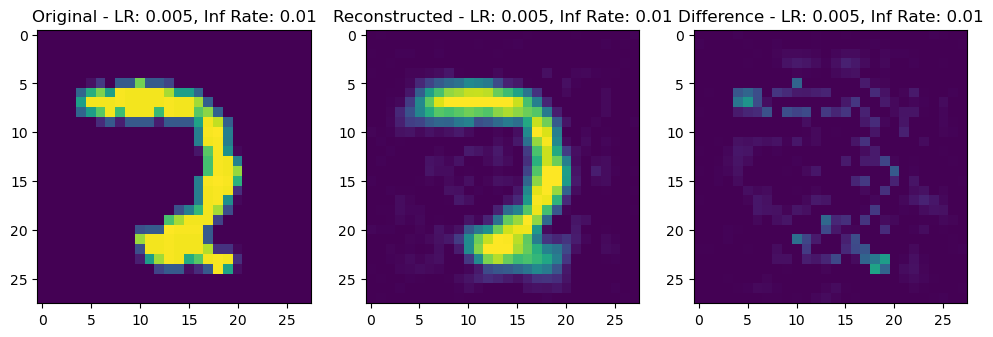

LR: 0.005, Inf Rate: 0.01, Average MSE: 0.0029593207090819165


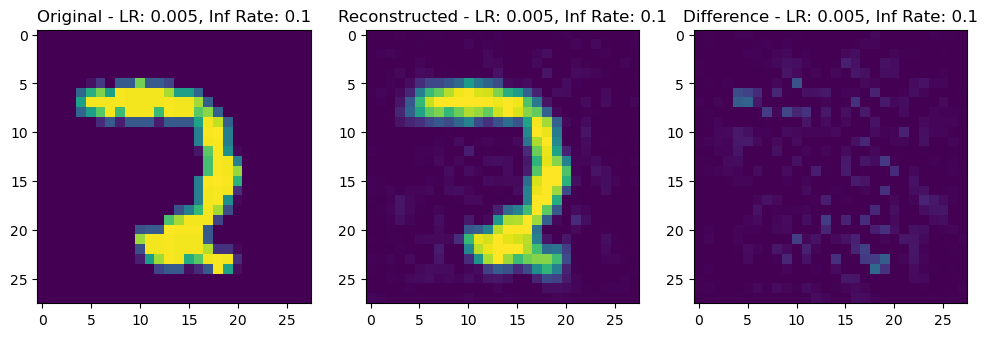

LR: 0.005, Inf Rate: 0.1, Average MSE: 0.0008568202466412618


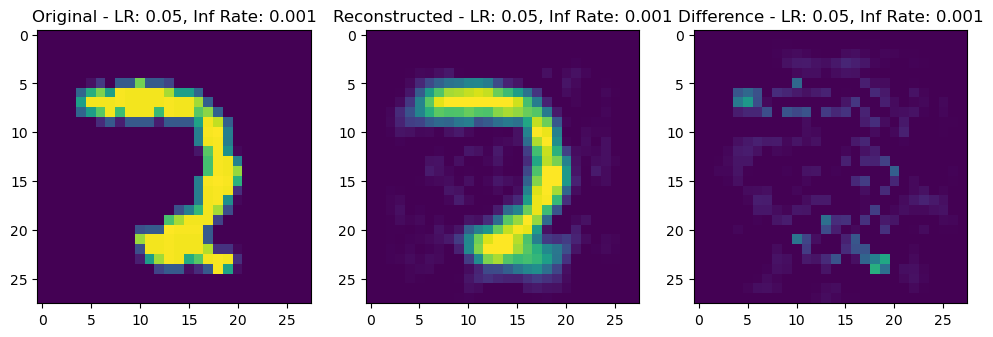

LR: 0.05, Inf Rate: 0.001, Average MSE: 0.0034660836810980165


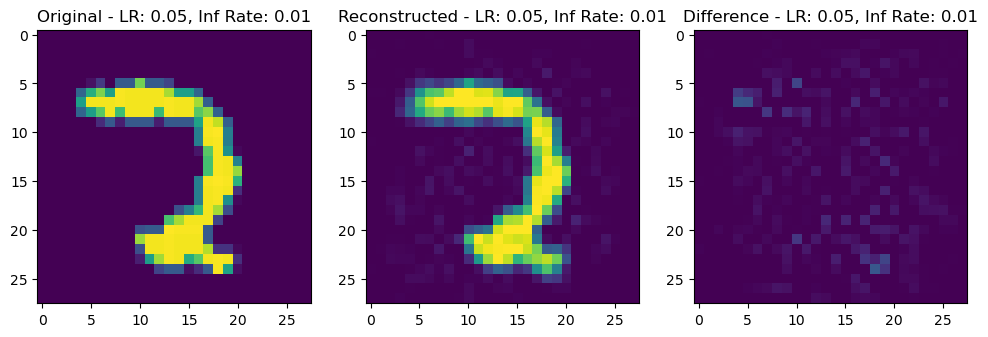

LR: 0.05, Inf Rate: 0.01, Average MSE: 0.00037143183916657816


C:\Users\31629\AppData\Local\Temp\ipykernel_10872\660535955.py:84: RuntimeWarning: overflow encountered in add
  self.r += dr
C:\Users\31629\AppData\Local\Temp\ipykernel_10872\660535955.py:84: RuntimeWarning: invalid value encountered in add
  self.r += dr


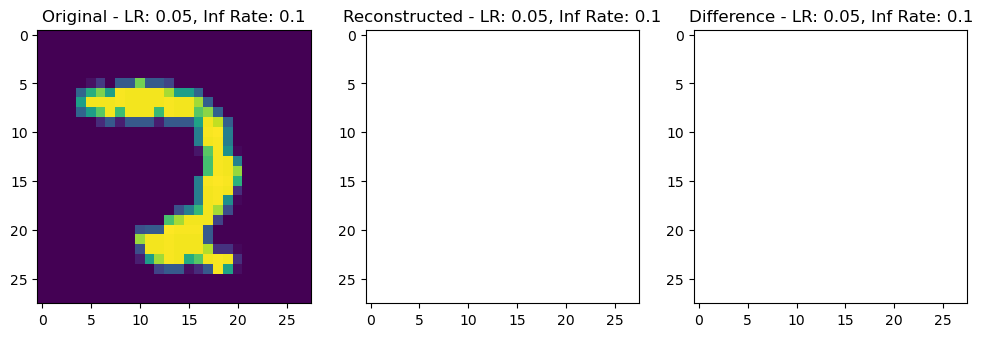

LR: 0.05, Inf Rate: 0.1, Average MSE: nan


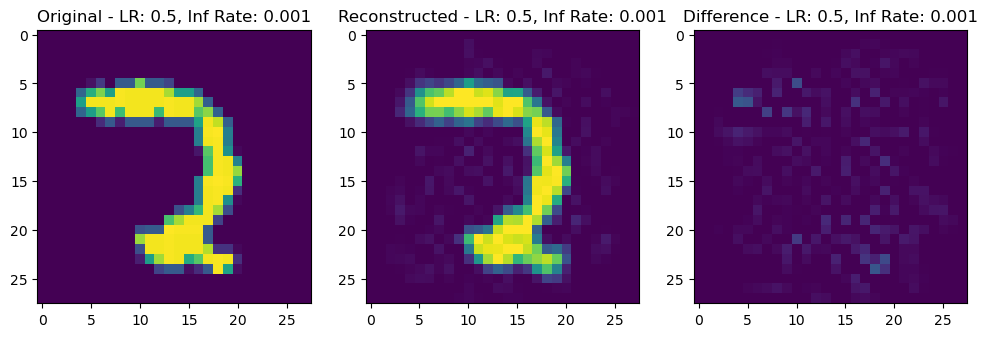

LR: 0.5, Inf Rate: 0.001, Average MSE: 0.00045250939108172134


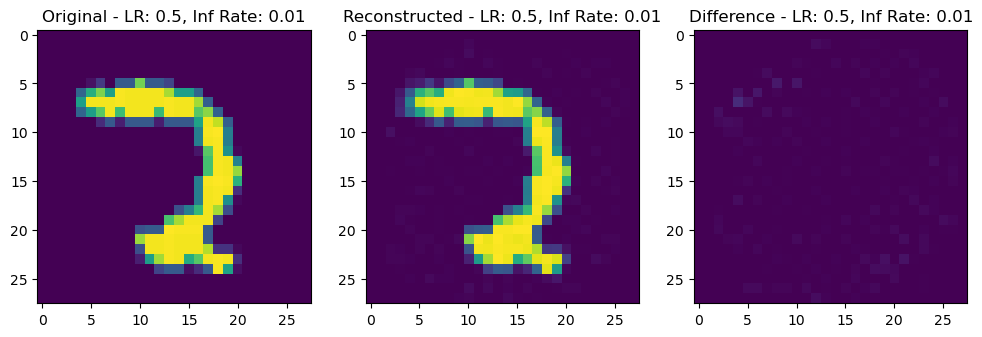

LR: 0.5, Inf Rate: 0.01, Average MSE: 2.7309889779711166e-05


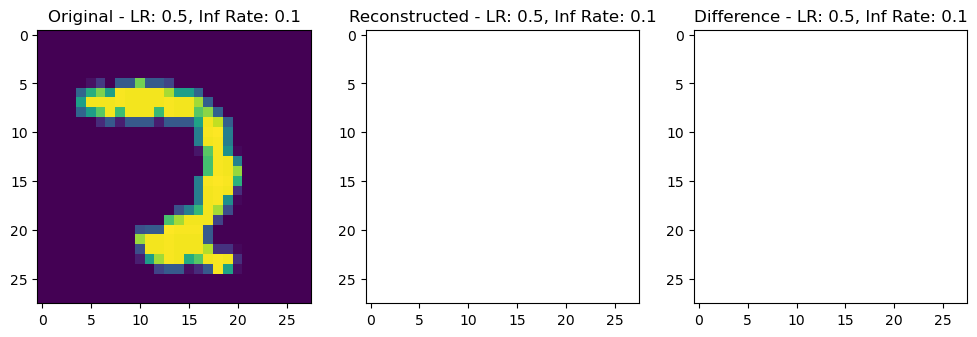

LR: 0.5, Inf Rate: 0.1, Average MSE: nan


In [161]:
from itertools import product

# Define the hyperparameters to search
learning_rates = [0.005, 0.05, 0.5]
inference_rates = [0.001, 0.01, 0.1]

# Loop over hyperparameters
for lr, inf_rate in product(learning_rates, inference_rates):
    # Create a new instance of the Network with current hyperparameters
    image_network = Network(mod1_image.architecture, n_iter_inference=40, inf_rate=inf_rate, learn_rate=lr, activation="relu")

    # Training loop
    mse_history_image = []
    epochs = 1
    for epoch in range(epochs):
        image_network.train(image_data_s_train, epochs=20)
        mse_visual = image_network.calculate_MSE()
        mse_history_image.append(mse_visual)

    # Inference and Visualization
    input_image = image_data_s_test[0]  # Use the first image for illustration
    image_network.infer(image=input_image, initialize=True)

    image_infer = image_network.reconstruct(layer=1)

    # Set up subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Visualize the original, reconstructed, and difference images
    axes[0].imshow(input_image.reshape(28, 28), vmin=0, vmax=1)
    axes[0].set_title(f'Original - LR: {lr}, Inf Rate: {inf_rate}')

    axes[1].imshow(image_infer.reshape(28, 28), vmin=0, vmax=1)
    axes[1].set_title(f'Reconstructed - LR: {lr}, Inf Rate: {inf_rate}')

    diff_images = input_image - image_infer
    axes[2].imshow(diff_images.reshape(28, 28), vmin=0, vmax=1)
    axes[2].set_title(f'Difference - LR: {lr}, Inf Rate: {inf_rate}')

    plt.show()

    # Calculate and print average MSE over the epochs for the first layer
    average_mse = np.mean([epoch[0] for epoch in mse_history_image])  # Assuming MSE is stored for each layer
    print(f'LR: {lr}, Inf Rate: {inf_rate}, Average MSE: {average_mse}')




and for audio 2 classes

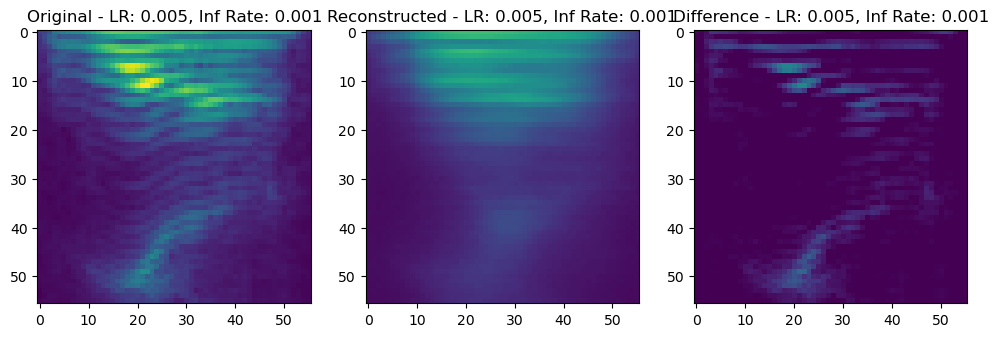

LR: 0.005, Inf Rate: 0.001, Average MSE: 0.008524035451021728


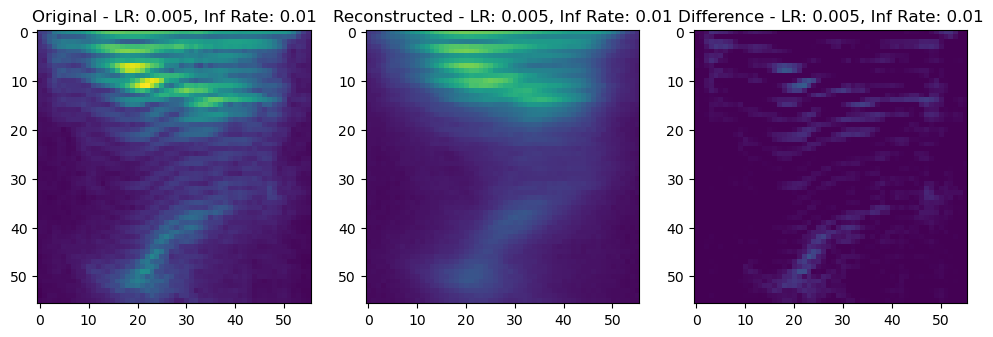

LR: 0.005, Inf Rate: 0.01, Average MSE: 0.00443166428213066


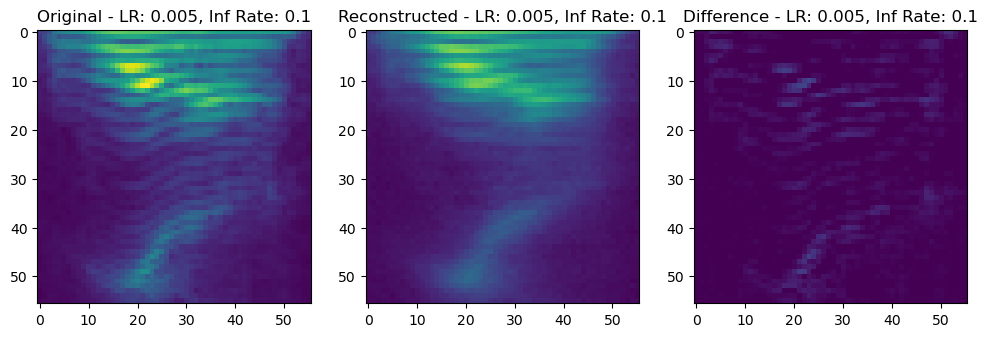

LR: 0.005, Inf Rate: 0.1, Average MSE: 0.002163428404735578


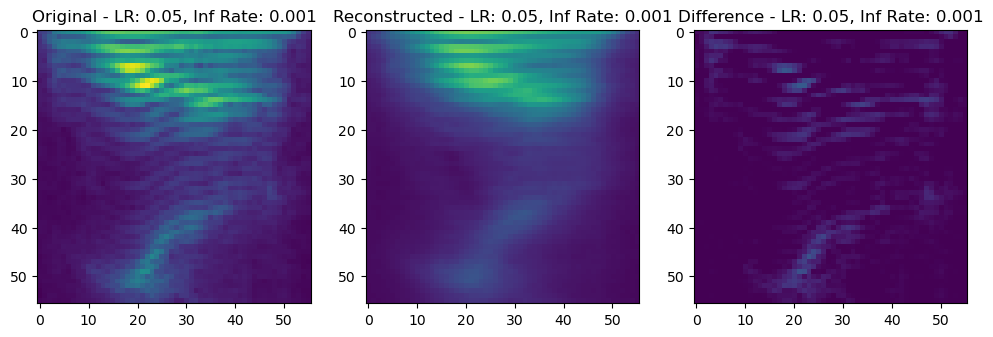

LR: 0.05, Inf Rate: 0.001, Average MSE: 0.005241246901282978


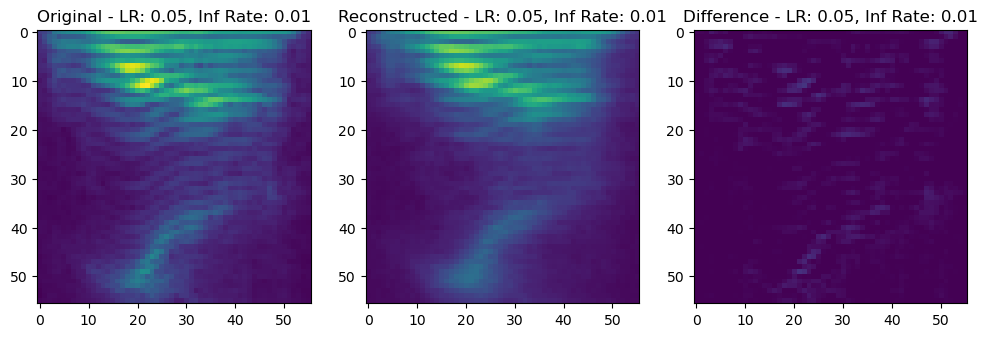

LR: 0.05, Inf Rate: 0.01, Average MSE: 0.0011160587149724557


C:\Users\31629\AppData\Local\Temp\ipykernel_10872\2996138432.py:84: RuntimeWarning: overflow encountered in add
  self.r += dr
C:\Users\31629\AppData\Local\Temp\ipykernel_10872\2996138432.py:84: RuntimeWarning: invalid value encountered in add
  self.r += dr


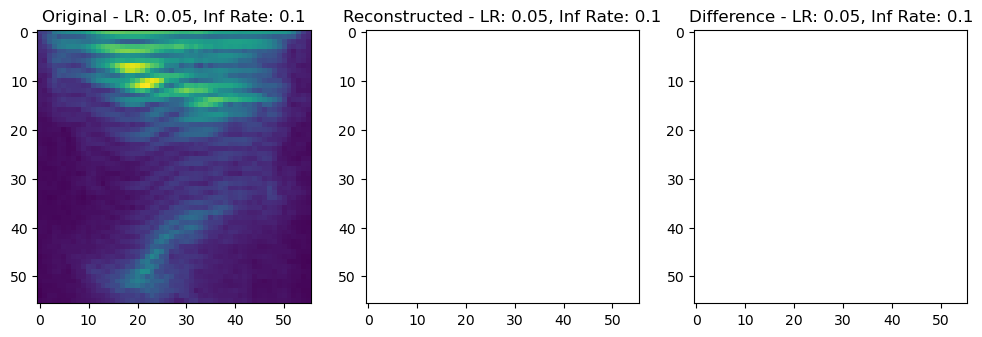

LR: 0.05, Inf Rate: 0.1, Average MSE: nan


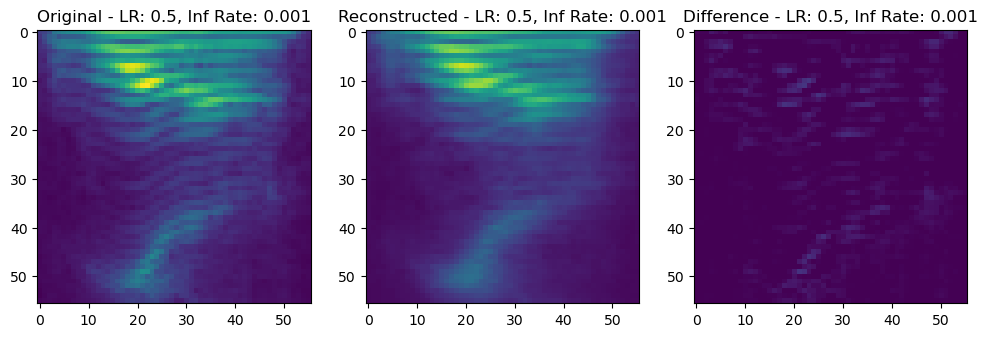

LR: 0.5, Inf Rate: 0.001, Average MSE: 0.001379462915041864


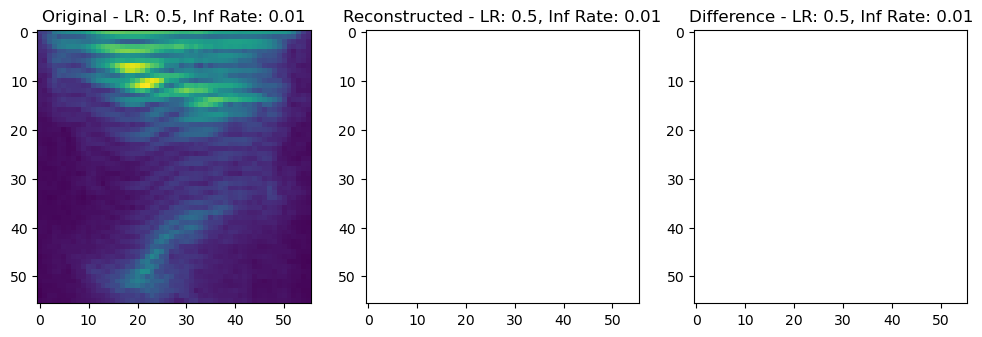

LR: 0.5, Inf Rate: 0.01, Average MSE: nan


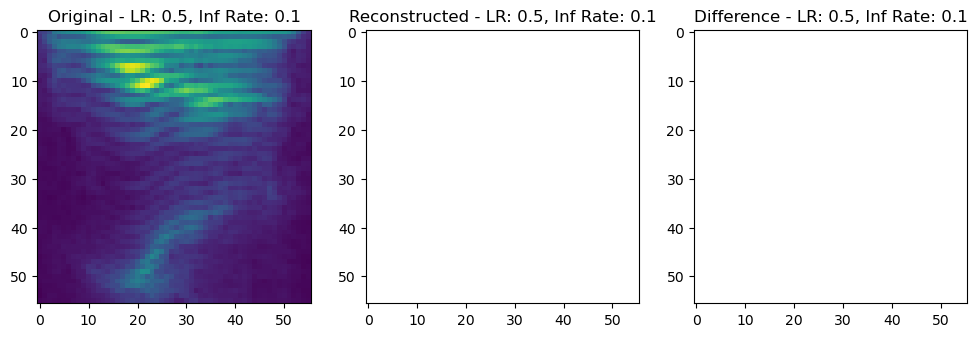

LR: 0.5, Inf Rate: 0.1, Average MSE: nan


In [191]:
from itertools import product

# Define the hyperparameters to search
learning_rates = [0.005, 0.05, 0.5]
inference_rates = [0.001, 0.01, 0.1]

# Loop over hyperparameters
for lr, inf_rate in product(learning_rates, inference_rates):
    # Create a new instance of the Network with current hyperparameters
    audio_network = Network(mod2_audio.architecture, n_iter_inference=40, inf_rate=inf_rate, learn_rate=lr, activation="relu")

    # Training loop
    mse_history_image = []
    epochs = 1
    for epoch in range(epochs):
        audio_network.train(audio_data_2_classes_s_train, epochs=10)
        mse_audio = audio_network.calculate_MSE()
        mse_history_image.append(mse_audio)

    # Inference and Visualization
    input_audio= audio_data_2_classes_s_test[0]  # Use the first image for illustration
    audio_network.infer(image=input_audio, initialize=True)

    audio_infer = audio_network.reconstruct(layer=1)

    # Set up subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Visualize the original, reconstructed, and difference images
    axes[0].imshow(input_audio.reshape(56, 56), vmin=0, vmax=1)
    axes[0].set_title(f'Original - LR: {lr}, Inf Rate: {inf_rate}')

    axes[1].imshow(audio_infer.reshape(56, 56), vmin=0, vmax=1)
    axes[1].set_title(f'Reconstructed - LR: {lr}, Inf Rate: {inf_rate}')

    diff_audios = input_audio - audio_infer
    axes[2].imshow(diff_audios.reshape(56, 56), vmin=0, vmax=1)
    axes[2].set_title(f'Difference - LR: {lr}, Inf Rate: {inf_rate}')

    plt.show()

    # Calculate and print average MSE over the epochs for the first layer
    average_mse = np.mean([epoch[0] for epoch in mse_history_image])  # Assuming MSE is stored for each layer
    print(f'LR: {lr}, Inf Rate: {inf_rate}, Average MSE: {average_mse}')

Visual: Learning rate 0.5, inference rate 0.01
Audio: Learning rate 0.05, inference rate 0.01